In [2]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

# Polynomial Features and Regularization

## Polynomial Features

In [19]:
ads = pd.read_csv('Advertising.csv', index_col=None)

In [20]:
ads.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [21]:
ads.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(ads[['TV',
                                                           'radio',
                                                          'newspaper']],
                                                   ads['sales'])

In [23]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)
lr1.score(X_test, y_test)

0.8330726393671096

### Blind Feature Engineering

We might try to improve our model by *multiplying features together*. Let's try adding a ```TV*newspaper``` column:

In [24]:
ads['TV*newspaper'] = ads['TV'] * ads['newspaper']
ads.head()

,TV,radio,newspaper,sales,TV*newspaper
0,230.1,37.8,69.2,22.1,15922.92
1,44.5,39.3,45.1,10.4,2006.95
2,17.2,45.9,69.3,9.3,1191.96
3,151.5,41.3,58.5,18.5,8862.75
4,180.8,10.8,58.4,12.9,10558.72


In [25]:
X_train, X_test, y_train, y_test = train_test_split(ads.drop('sales', axis=1), ads['sales'])

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.860892867724311

### Improving Our Model with Polynomial Features!

Instead of just guessing at which products of features would help, let's take the GOFAI approach of trying ***all of them at once!***

In [27]:
pf = PolynomialFeatures()
pf.fit_transform(ads[['TV', 'radio', 'newspaper']], ads['sales'])

array([[1.00000e+00, 2.30100e+02, 3.78000e+01, ..., 1.42884e+03,
        2.61576e+03, 4.78864e+03],
       [1.00000e+00, 4.45000e+01, 3.93000e+01, ..., 1.54449e+03,
        1.77243e+03, 2.03401e+03],
       [1.00000e+00, 1.72000e+01, 4.59000e+01, ..., 2.10681e+03,
        3.18087e+03, 4.80249e+03],
       ...,
       [1.00000e+00, 1.77000e+02, 9.30000e+00, ..., 8.64900e+01,
        5.95200e+01, 4.09600e+01],
       [1.00000e+00, 2.83600e+02, 4.20000e+01, ..., 1.76400e+03,
        2.78040e+03, 4.38244e+03],
       [1.00000e+00, 2.32100e+02, 8.60000e+00, ..., 7.39600e+01,
        7.48200e+01, 7.56900e+01]])

In [28]:
pf_sales = pd.DataFrame(pf.fit_transform(ads[['TV', 'radio',
                                               'newspaper']],),
                       columns=pf.get_feature_names(['TV', 'radio',
                                                   'newspaper']))

In [29]:
pf_sales.head()

,1,TV,radio,newspaper,TV^2,TV radio,TV newspaper,radio^2,radio newspaper,newspaper^2
0,1.0,230.1,37.8,69.2,52946.01,8697.78,15922.92,1428.84,2615.76,4788.64
1,1.0,44.5,39.3,45.1,1980.25,1748.85,2006.95,1544.49,1772.43,2034.01
2,1.0,17.2,45.9,69.3,295.84,789.48,1191.96,2106.81,3180.87,4802.49
3,1.0,151.5,41.3,58.5,22952.25,6256.95,8862.75,1705.69,2416.05,3422.25
4,1.0,180.8,10.8,58.4,32688.64,1952.64,10558.72,116.64,630.72,3410.56


In [30]:
X_train, X_test, y_train, y_test = train_test_split(pf_sales,
                                                    ads['sales'])

In [31]:
pr = LinearRegression()
pr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
pr.score(X_test, y_test)

0.9942822467222219

In [33]:
pf_y = pd.concat([pf_sales[['TV', 'radio', 'newspaper', 'TV radio',
                            'TV newspaper']],
                  ads['sales']],  axis=1)

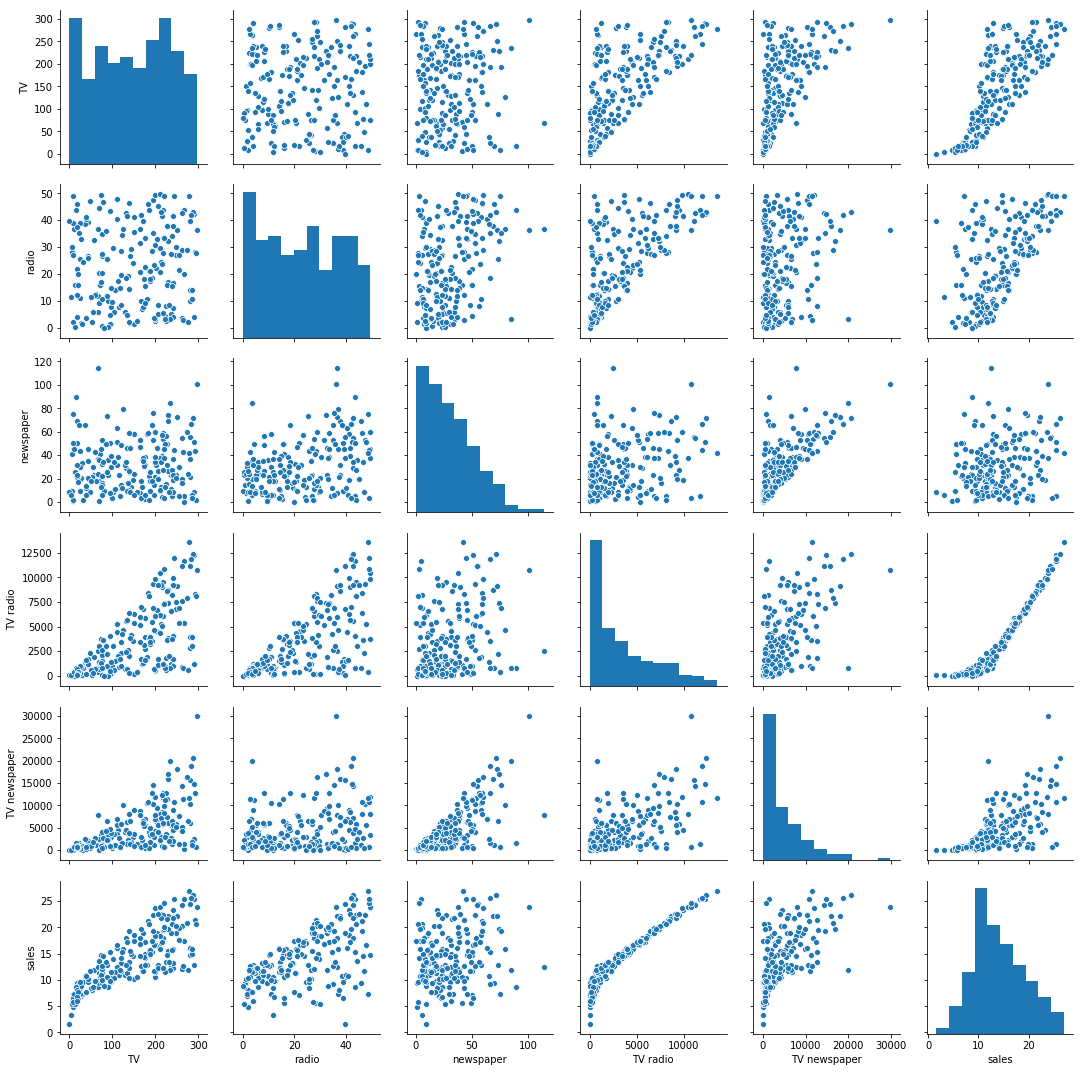

In [34]:
sns.pairplot(pf_y);

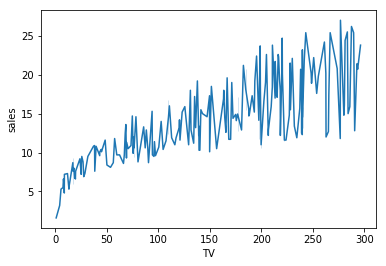

In [37]:
sns.lineplot(ads['TV'], ads['sales']);

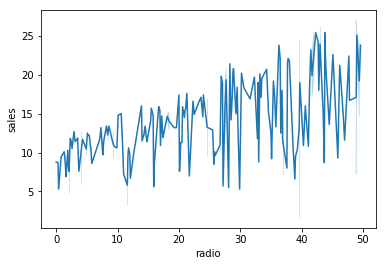

In [39]:
sns.lineplot(ads['radio'], ads['sales']);

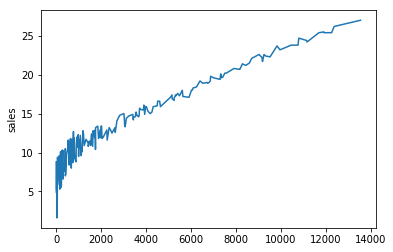

In [38]:
sns.lineplot(ads['TV']*ads['radio'], ads['sales']);

## Regularization

### Bias and Variance

High bias is easy to wrap one's mind around: Imagine pulling three red balls from an urn that has hundreds of balls of all colors in a uniform distribution. Then my sample is a terrible representative of the whole population. If I were to build a model by extrapolating from my sample, that model would predict that _every_ ball produced would be red! That is, this model would be incredibly biased.

High variance is a little bit harder to visualize, but it's basically the "opposite" of this. Imagine that the population of balls in the urn is mostly red, but also that there are a few balls of other colors floating around. Now imagine that our sample comprises a few balls, none of which is red. In this case, we've essentially picked up on the "noise", rather than the "signal". If I were to build a model by extrapolating from my sample, that model would be needlessly complex. It might predict that balls drawn before noon will be orange and that balls drawn after 8pm will be green, when the reality is that a simple model that predicted 'red' for all balls would be a superior model!

The important idea here is that there is a _trade-off_: If we have too few data in our sample (training set), or too few predictors, we run the risk of high _bias_, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high _variance_, i.e. an overfit model.

https://en.wikipedia.org/wiki/Overfitting#/media/File:Overfitting.svg

### Changing Our Loss Function

Suppose I have split my data into training and testing sets. Do I want my model to fit my training data _exactly_?

Often, the answer is actually 'NO!', because doing that will lead to an overfit model.

Overfitting is generally a result of high variance. High variance can be caused by:
- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The first problem is about picking up on noise rather than signal.
The second problem is about having a least-squares estimate that is highly sensitive to random error.
The third is about having highly sensitive predictors.

Regularization is about introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

There are two popular ways of doing this:

Lasso ("L1"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|]$
<br/> <br/>

Ridge ("L2"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

**$\rightarrow$ Don't let these formulas be intimidating. The first term in each of these (the sum of squares) is the same, and is just the familiar loss function that we've always used. What distinguishes the Lasso Regression from the Ridge Regression is only the extra term on the right. The Lasso uses the absolute values of the coefficients, while the Ridge uses the squares of the coefficients.**

For a given value of $\lambda$, the Ridge makes for a gentler reining in of runaway coefficients. The Lasso will more quickly reduce the contribution of individual predictors down to insignificance.

For a nice discussion of these methods in Python, see https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b.

In [25]:
wine = pd.read_csv('winequality_merged.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [37]:
wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
red_wine                  int64
dtype: object

In [26]:
X = wine.drop('quality', axis=1)
y = wine['quality']

In [27]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
# Now let's scale our data.

ss = StandardScaler()
ss_fit = ss.fit(X_train)

X_tr_scaled = ss_fit.transform(X_train)

/Users/gdamico/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gdamico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [29]:
# Scaling test set

X_te_scaled = ss_fit.transform(X_test)

/Users/gdamico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
# Fitting a Linear Regression

lr2 = LinearRegression()
lr2.fit(X_tr_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [31]:
# Scoring the model on the test set

lr2.score(X_te_scaled, y_test)

0.29272979464657356

In [116]:
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_pf = pf.fit_transform(X.values)

In [117]:
w_train, w_test, q_train, q_test = train_test_split(X_pf, wine['quality'])

In [118]:
ss2 = StandardScaler()
ss2_fit = ss2.fit(w_train)

w_tr_pfs = ss2_fit.transform(w_train)

w_te_pfs = ss2_fit.transform(w_test)

In [119]:
lr3 = LinearRegression()
lr3.fit(w_tr_pfs, q_train)
lr3.score(w_tr_pfs, q_train)

0.36850454726159876

In [120]:
lr3.score(w_te_pfs, q_test)

0.3222820311661645

### Regularization in Python with Scikit-Learn

In [121]:
# reg_l = Lasso(alpha=0.5)

reg_l = Lasso(alpha=0.05)

In [122]:
# Fitting the Lasso

reg_l.fit(w_tr_pfs, q_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
# Scoring the Lasso on the training data

reg_l.score(w_tr_pfs, q_train)

0.2654604430741384

In [124]:
# Scoring the Lasso on the test data

reg_l.score(w_te_pfs, q_test)

0.28417120598642975

In [125]:
reg_l.coef_

array([-0.        , -0.11973877,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.02432331, -0.04552849, -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02100376,  0.        ,
       -0.        , -0.00506723, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.02675154, -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.  

In [126]:
# reg_r = Ridge(alpha=)

reg_r = Ridge(alpha=20)

In [127]:
# Fitting the Ridge

reg_r.fit(w_tr_pfs, q_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [128]:
# Scoring the Ridge on the training data

reg_r.score(w_tr_pfs, q_train)

0.3508241631495995

In [129]:
# Scoring the Ridge on the test data

reg_r.score(w_te_pfs, q_test)

0.32791970079612287

In [130]:
reg_r.coef_

array([ 0.00090861, -0.19077002, -0.0232367 ,  0.14520596,  0.15002244,
        0.00385602,  0.09685924, -0.26432486, -0.02426711,  0.01710322,
       -0.01275551,  0.05474229, -0.19888262, -0.20971552,  0.24737908,
       -0.02894426,  0.07034299,  0.03455449,  0.00313495,  0.11097664,
        0.09793988, -0.07365317,  0.3981349 ,  0.06792438, -0.04644443,
        0.00266887,  0.01957083,  0.07163927, -0.19092307, -0.20867768,
        0.03375739,  0.32142049,  0.28671867, -0.02376853,  0.07013365,
        0.10844412, -0.13944164, -0.0254545 ,  0.1200968 , -0.11403654,
        0.15274628, -0.07895252, -0.02215386, -0.23738768,  0.1764728 ,
        0.16371016, -0.1247303 , -0.00504973, -0.0492017 ,  0.0033581 ,
       -0.01570114,  0.02180124,  0.15443869, -0.11287985, -0.13507531,
       -0.20721981,  0.08480505, -0.38811927, -0.00098194,  0.02147309,
        0.16516946,  0.14309828, -0.15286668,  0.09428352,  0.10364568,
       -0.36236447,  0.07833267, -0.0746022 , -0.06450692,  0.01

### Elastic Net

There is a combination of L1 and L2 regularization called the Elastic Net that can also be used. The idea is to use a weighted sum of the Lasso and the Ridge, where the weights add up to 100%. We might want 50% of each, but we also might want, say, 10% Lasso and 90% Ridge.

The loss function for an Elastic Net Regression looks like this:

Elastic Net: Minimize $\large\rho\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|] + (1 - \rho)\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

Sometimes you will see this loss function represented with different scaling terms, but the basic idea is to have a combination of L1 and L2 regularization terms.

### Coding the Elastic Net

Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is ```l1_ratio```.

In [102]:
# Creating the Elastic Net Regression
enet = ElasticNet(alpha=0.2, l1_ratio=0.2)

In [103]:
# Fitting the Elastic Net

enet.fit(w_tr_pfs, q_train)

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [104]:
# Scoring the Elastic Net on train ...

enet.score(w_tr_pfs, q_train)

0.2778168541759922

In [105]:
# ... and on test

enet.score(w_te_pfs, q_test)

0.26169742298625986